In [123]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.optimizers import Adadelta
from keras.backend import get_session

In [124]:
# For abdomen
abdomen_path = 'C:/Users/ABMI/Desktop/classification/abdomen' 
abdomen_list = []
for (path, dir, files) in os.walk(abdomen_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.dcm':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            abdomen_list.append(filePath)

In [125]:
len(abdomen_list)

1231

In [126]:
# Create Data Frame
# abdomen = 0
abdomen_df = pd.DataFrame(data={'filename': abdomen_list, 'label': [0 for i in range(len(abdomen_list))]})

In [127]:
# For chestAP
chestAP_path = 'C:/Users/ABMI/Desktop/classification/chest AP' 
chestAP_list = []
for (path, dir, files) in os.walk(chestAP_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.dcm':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            chestAP_list.append(filePath)

In [128]:
len(chestAP_list)

1293

In [129]:
# Create Data Frame
# chestAP = 1
chestAP_df = pd.DataFrame(data={'filename': chestAP_list, 'label': [1 for i in range(len(chestAP_list))]})

In [130]:
# For chestPA
chestPA_path = 'C:/Users/ABMI/Desktop/classification/chest PA' 
chestPA_list = []
for (path, dir, files) in os.walk(chestPA_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.dcm':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            chestPA_list.append(filePath)

In [131]:
len(chestPA_list)

654

In [132]:
# Create Data Frame
# chestPA = 2
chestPA_df = pd.DataFrame(data={'filename': chestPA_list, 'label': [2 for i in range(len(chestPA_list))]})

In [133]:
# append all dataframe and do one hot encoding(+shuffle dataframe)
total_df=abdomen_df.append(chestAP_df)
total_df=total_df.append(chestPA_df)
label=total_df[['label']]

tmp1 = total_df[['filename']]
tmp2 = label
tmp1.reset_index(drop=True,inplace=True)
tmp2.reset_index(drop=True,inplace=True)
df=pd.concat([tmp1,tmp2],axis=1)
df.columns=['filename', 'label']
df=df.sample(frac=1)

In [134]:
y_train = np.array(df['label'].tolist())
y_train = keras.utils.np_utils.to_categorical(y_train)

In [135]:
x_train=[]
for i in df['filename'].values:
    a=pydicom.filereader.dcmread(str(i)).pixel_array
    a=cv2.resize(a, (128, 128))
    x_train.append(a)
x_train=np.array(x_train)  

In [136]:
x_train = x_train.reshape(3178, 128, 128, 1).astype('float32')

In [137]:
#Pixel positive global standardization
from numpy import clip
for i in range(len(x_train)):
    mean, std = x_train[i].mean(), x_train[i].std()
    x_train[i] = (x_train[i] - mean) / std
    x_train[i] = clip(x_train[i], -1.0, 1.0)
    x_train[i] = (x_train[i] + 1.0) / 2.0

In [138]:
x_val=x_train[2178:2678]
y_val=y_train[2178:2678]
x_test=x_train[2678:]
y_test=y_train[2678:]

In [139]:
x_train=x_train[:2178]
y_train=y_train[:2178]

In [141]:
def cnn(size):
    KERNEL = (8,8)
    shape = (size[0], size[1], size[2])
    
    # Define Model
    model = Sequential()
    
    # Add Convolution 1
    model.add(Conv2D(filters=8, kernel_size=KERNEL, activation='relu', input_shape=shape))
    
    # Add Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Add Convolution 2
    model.add(Conv2D(filters=16, kernel_size=KERNEL, activation='relu', input_shape=shape))
    
    # Add Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Add Convolution 3
    model.add(Conv2D(filters=32, kernel_size=KERNEL, activation='relu', input_shape=shape))
    
    # Add Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    
    # Add Output Layer
    model.add(Dropout(0.5))
    model.add(Dense(units=3, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
    model.summary()
    
    return model

model = cnn(size=x_train.shape[1:])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 121, 121, 8)       520       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 60, 60, 8)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 53, 53, 16)        8208      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 19, 19, 32)       

In [142]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val))

Train on 2178 samples, validate on 500 samples
Epoch 1/100
2178/2178 [==============================] - 20s 9ms/step - loss: 0.9062 - accuracy: 0.6079 - val_loss: 0.6521 - val_accuracy: 0.7420
Epoch 2/100
2178/2178 [==============================] - 18s 8ms/step - loss: 0.5498 - accuracy: 0.7668 - val_loss: 0.7025 - val_accuracy: 0.6360
Epoch 3/100
2178/2178 [==============================] - 18s 8ms/step - loss: 0.5103 - accuracy: 0.7911 - val_loss: 0.5133 - val_accuracy: 0.7260
Epoch 4/100
2178/2178 [==============================] - 19s 9ms/step - loss: 0.4626 - accuracy: 0.8053 - val_loss: 0.3125 - val_accuracy: 0.8960
Epoch 5/100
2178/2178 [==============================] - 19s 9ms/step - loss: 0.3916 - accuracy: 0.8425 - val_loss: 0.4046 - val_accuracy: 0.8580
Epoch 6/100
2178/2178 [==============================] - 20s 9ms/step - loss: 0.3886 - accuracy: 0.8609 - val_loss: 0.4308 - val_accuracy: 0.8340
Epoch 7/100
2178/2178 [==============================] - 20s 9ms/step - loss:

In [143]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = model.predict_proba(x_test)
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [144]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

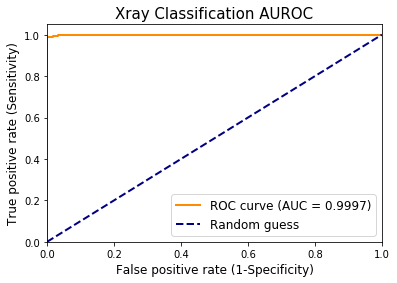

In [145]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', 
         lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (1-Specificity)', fontsize=12)
plt.ylabel('True positive rate (Sensitivity)', fontsize=12)
plt.title('Xray Classification AUROC', fontsize=15)
plt.legend(loc="lower right", fontsize=12)

fig = plt.gcf()
plt.show()
fig.savefig('Cancer_AUROC.png')

In [147]:
# 테스트 데이터로 평가하기
score = model.evaluate(x_test, y_test, verbose=1)
print('loss=', score[0])
print('accuracy=', score[1])

500/500 [==============================] - 1s 2ms/step
loss= 0.12820569372177124
accuracy= 0.9679999947547913


In [ ]:
##########################################################################################

In [23]:
# Transcope (Warning: Please only one run)
from PIL import Image

trans_target = normal_df

root_path = './AJOU/Normal/' 
trans_list = []

for filename in trans_target['filename']:
    non_ext = os.path.splitext(filename)[0]
    o_filename = os.path.split(non_ext)[-1]
    
    # Read Original Image
    origin = Image.open(filename)
    
    # TOP_BOTTOM
    trans = origin.transpose(Image.FLIP_TOP_BOTTOM)
    m_filename = root_path + o_filename + '-{0}'.format('TB_TRANS.jpg')
    trans.save(m_filename)
    trans_list.append(m_filename)
    
    # LEFT_RIGHT
    trans = origin.transpose(Image.FLIP_LEFT_RIGHT)
    m_filename = root_path + o_filename + '-{0}'.format('LR_TRANS.jpg')
    trans.save(m_filename)
    trans_list.append(m_filename)
    
tmp_df = pd.DataFrame({'filename': trans_list, 'label': [0 for i in range(len(trans_list))]})
normal_df = normal_df.append(tmp_df)

In [24]:
len(trans_list)

562

In [17]:
# Transcope (Warning: Please only one run)
from PIL import Image

trans_target = cancer_df

root_path = './AJOU/Cancer/' 
trans_list = []

for filename in trans_target['filename']:
    non_ext = os.path.splitext(filename)[0]
    o_filename = os.path.split(non_ext)[-1]
    
    # Read Original Image
    origin = Image.open(filename)
    
    # TOP_BOTTOM
    trans = origin.transpose(Image.FLIP_TOP_BOTTOM)
    m_filename = root_path + o_filename + '-{0}'.format('TB_TRANS.jpg')
    trans.save(m_filename)
    trans_list.append(m_filename)
    
    # LEFT_RIGHT
    trans = origin.transpose(Image.FLIP_LEFT_RIGHT)
    m_filename = root_path + o_filename + '-{0}'.format('LR_TRANS.jpg')
    trans.save(m_filename)
    trans_list.append(m_filename)
    
tmp_df = pd.DataFrame({'filename': trans_list, 'label': [0 for i in range(len(trans_list))]})
cancer_df = cancer_df.append(tmp_df)

In [26]:
len(trans_list)

562

In [27]:
len(cancer_df)

729

In [146]:
# Rotate (Warning: Please only one run) # 이 부분 생략함

rotate_target = normal_df

root_path = './Normal/'
rotate_list = []

for filename in rotate_target['filename']:
    
    # Load basename
    non_ext = os.path.splitext(filename)[0]
    o_filename = os.path.split(non_ext)[-1]
    
    # Read Original Image
    origin = Image.open(filename)
    
    # 90"
    rot = origin.rotate(90, expand=1)
    m_filename = root_path + o_filename + '-{0}'.format('90.jpg')

    rot.save(m_filename)
    rotate_list.append(m_filename)
    
    # 180"
    rot = origin.rotate(180, expand=1)
    m_filename = root_path + o_filename + '-{0}'.format('180.jpg')
    
    rot.save(m_filename)
    rotate_list.append(m_filename)
    
    # 270"
    rot = origin.rotate(-90, expand=1)
    m_filename = root_path + o_filename + '-{0}'.format('270.jpg')
    
    rot.save(m_filename)
    rotate_list.append(m_filename)
    
tmp_df = pd.DataFrame({'filename': rotate_list, 'label': [0 for i in range(len(rotate_list))]})
normal_df = normal_df.append(tmp_df)

In [147]:
#len(rotate_list)

837

In [28]:
len(normal_df)

843

In [29]:
len(cancer_df)

729

In [30]:
# Merge ImageList
roi_img_df = cancer_df.append(normal_df)

In [31]:
len(roi_img_df)

1572

In [32]:
# Shuffle
sh_df = roi_img_df.sample(frac=1).reset_index(drop=True)

In [33]:
len(sh_df)

1572

In [34]:
from matplotlib.image import imread

im_list = []

# Read Image
for path in sh_df['filename']:
    img = imread(path)
    im_list.append(img)

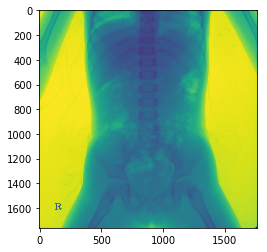

In [14]:
import matplotlib.pyplot as plt

def showImage(img):
    plt.imshow(img)    
    plt.show()

# Draw Image
showImage(pydicom.filereader.dcmread(abdomen_list[1]).pixel_array)

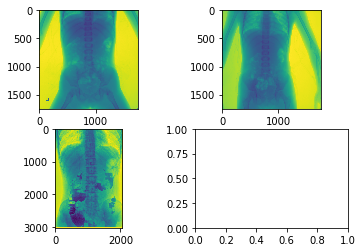

In [20]:

f, axarr = plt.subplots(2,2)

axarr[0,0].imshow(pydicom.filereader.dcmread(abdomen_list[1]).pixel_array) # R
axarr[0,1].imshow(pydicom.filereader.dcmread(abdomen_list[2]).pixel_array) # G
axarr[1,0].imshow(pydicom.filereader.dcmread(abdomen_list[3]).pixel_array) # B
    


In [16]:
print(pydicom.filereader.dcmread(abdomen_list[1]).pixel_array)
print(type(pydicom.filereader.dcmread(abdomen_list[1]).pixel_array))

[[ 0  9  0 ...  0 12  0]
 [21  0 25 ...  4  0  8]
 [ 0 30  0 ...  0 17  0]
 ...
 [ 0 24  0 ...  0 12  0]
 [25  0 39 ...  0  0  0]
 [ 0 12  0 ...  0  3  1]]
<class 'numpy.ndarray'>


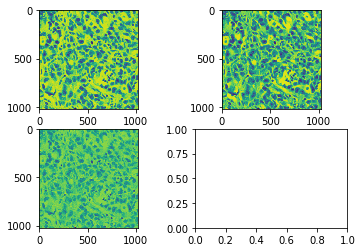

In [36]:
# Seperate Color Image View
def showImages(input_img):
    f, axarr = plt.subplots(2,2)

    axarr[0,0].imshow(input_img[...,0]) # R
    axarr[0,1].imshow(input_img[...,1]) # G
    axarr[1,0].imshow(input_img[...,2]) # B
    
    return

showImages(im_list[224])

In [37]:
# Visualization
def visualize_data(cancer_images, normal_images):
    # INPUTS
    # positive_images - Images where the label = 1 (True)
    # negative_images - Images where the label = 0 (False)
 
    figure = plt.figure()
    count = 0
 
    for i in range(cancer_images.shape[0]):
        count += 1
        figure.add_subplot(2, cancer_images.shape[0], count)
        plt.imshow(cancer_images[i, :, :])
        plt.axis('off')
        plt.title("C".format(i))
 
        figure.add_subplot(1, normal_images.shape[0], count)
        plt.imshow(normal_images[i, :, :])
        plt.axis('off')
        plt.title("N".format(i), y=-0.3)
        
    plt.show()

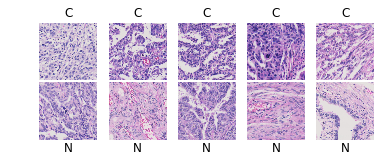

In [38]:
import numpy as np

x = np.array(im_list)
y = np.array(sh_df['label'])

# Number of positive and negative examples to show
N_TO_VISUALIZE = 5
 
# Select the first N Cancer examples
positive_example_indices = (y == 1)
positive_examples = x[positive_example_indices, :, :]
positive_examples = positive_examples[0:N_TO_VISUALIZE, :, :]
 
# Select the first N Normal examples
negative_example_indices = (y == 0)
negative_examples = x[negative_example_indices, :, :]
negative_examples = negative_examples[0:N_TO_VISUALIZE, :, :]
 
# Call the visualization function
visualize_data(positive_examples, negative_examples)

In [39]:
from PIL import Image

# Resize Image
train = []

for img in x:
    arr = Image.fromarray(img)
    res = arr.resize((128, 128))
    train.append(np.array(res))
    
train = np.array(train)

In [40]:
from sklearn.model_selection import train_test_split

# Split Data
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.2)

In [41]:
# Generalize
x_train = x_train / 255
x_test = x_test / 255

In [42]:
print('training dataset =',len(x_train))
print('test dataset     =',len(x_test))

training dataset = 1257
test dataset     = 315


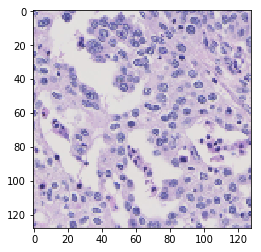

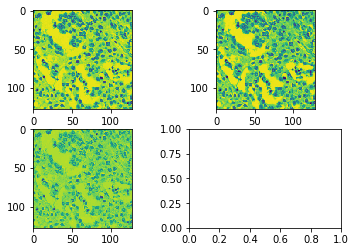

In [43]:
# x_train[,100:200,100:200,]

showImage(x_test[224])
showImages(x_test[224])

In [44]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [45]:
y_train = to_categorical(y_train,num_classes=2)
y_test = to_categorical(y_test,num_classes=2)

In [46]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.optimizers import Adadelta
from keras.backend import get_session

In [101]:
def cnn(size):
    KERNEL = (8,8)
    shape = (size[0], size[1], size[2])
    
    # Define Model
    model = Sequential()
    
    # Add Convolution 1
    model.add(Conv2D(filters=8, kernel_size=KERNEL, activation='relu', input_shape=shape))
    
    # Add Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Add Convolution 2
    model.add(Conv2D(filters=16, kernel_size=KERNEL, activation='relu', input_shape=shape))
    
    # Add Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Add Convolution 3
    model.add(Conv2D(filters=32, kernel_size=KERNEL, activation='relu', input_shape=shape))
    
    # Add Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    
    # Add Output Layer
    model.add(Dropout(0.5))
    model.add(Dense(units=3, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
    model.summary()
    
    return model

model = cnn(size=x_train.shape[1:])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 121, 121, 8)       520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 16)        8208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 32)       

In [102]:
x_train.shape[1:]

(128, 128, 1)

In [116]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val))

Train on 2178 samples, validate on 500 samples
Epoch 1/100
2178/2178 [==============================] - 15s 7ms/step - loss: 0.3907 - accuracy: 0.8655 - val_loss: 0.3225 - val_accuracy: 0.9000
Epoch 2/100
2178/2178 [==============================] - 15s 7ms/step - loss: 0.2962 - accuracy: 0.8976 - val_loss: 0.2084 - val_accuracy: 0.9500
Epoch 3/100
2178/2178 [==============================] - 15s 7ms/step - loss: 0.2336 - accuracy: 0.9261 - val_loss: 0.2437 - val_accuracy: 0.9320
Epoch 4/100
2178/2178 [==============================] - 15s 7ms/step - loss: 0.2613 - accuracy: 0.9229 - val_loss: 0.2355 - val_accuracy: 0.9180
Epoch 5/100
2178/2178 [==============================] - 16s 7ms/step - loss: 0.2151 - accuracy: 0.9343 - val_loss: 0.1551 - val_accuracy: 0.9640
Epoch 6/100
2178/2178 [==============================] - 15s 7ms/step - loss: 0.2374 - accuracy: 0.9247 - val_loss: 0.1510 - val_accuracy: 0.9660
Epoch 7/100
2178/2178 [==============================] - 15s 7ms/step - loss:

In [131]:
hist.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

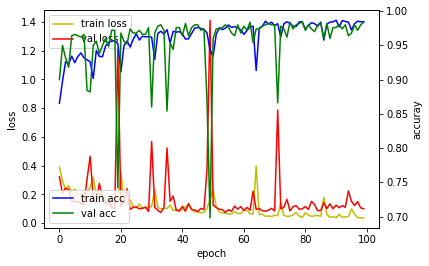

In [132]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

fig = plt.gcf()
plt.show()
fig.savefig('result-2.png')

In [118]:
# 테스트 데이터로 평가하기
score = model.evaluate(x_test, y_test, verbose=1)
print('loss=', score[0])
print('accuracy=', score[1])

500/500 [==============================] - 1s 2ms/step
loss= 0.1383575963564217
accuracy= 0.984000027179718


In [ ]:
from livelossplot.keras import PlotLossesCallback

hist = model.fit(x_train, y_train, epochs=3, batch_size=128, validation_data=(x_val, y_val), callbacks=[PlotLossesCallback()], verbose=0)

In [119]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = model.predict_proba(x_test)
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [120]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

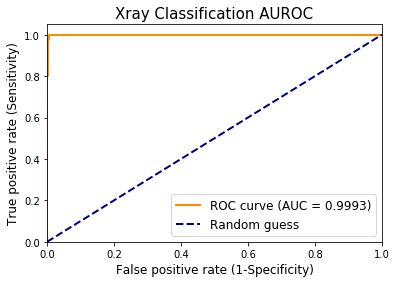

In [121]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', 
         lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (1-Specificity)', fontsize=12)
plt.ylabel('True positive rate (Sensitivity)', fontsize=12)
plt.title('Xray Classification AUROC', fontsize=15)
plt.legend(loc="lower right", fontsize=12)

fig = plt.gcf()
plt.show()
fig.savefig('Cancer_AUROC.png')

In [133]:
loss_and_matrics=model.evaluate(x_test, y_test, batch_size=32)
print(loss_and_matrics)

500/500 [==============================] - 1s 2ms/step
[0.1383575963564217, 0.984000027179718]


In [134]:
# 모델 저장하기
from keras.models import load_model
model.save('Model_CancerClassification_v1.h5')

In [2]:
import tensorflow as tf
tf.

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'